In [ ]:
import pickle
import numpy as np
import pandas as pd
import os
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
import models.util as util

MODEL_PATH = 'models/out/lstm/config_v256d03.h5'
SCALER_PATH = 'models/out/lstm/config_v256d03_scalers.pkl'

with open(SCALER_PATH, 'rb') as f:
    config = pickle.load(f)
model = load_model(MODEL_PATH, compile=False)

# Set path to local data directory
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load and combine parquet files
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# Load time reference
time_ref_path = os.path.join(folder_path, "time_id_reference.csv")
time_ref_df = pd.read_csv(time_ref_path)
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])

# Filter one stock for now
df_raw = combined_df[combined_df["stock_id"] == 50200].copy()

# Step 1: Compute snapshot features
snapshot_features_df = util.create_snapshot_features(df_raw)

# Step 2: Compute rolling-window training set
rolling_features_df = util.generate_rolling_features(snapshot_features_df)

# Merge time_id to datetime (optional for plotting/debugging)
rolling_features_df = pd.merge(
    rolling_features_df.drop(columns=["datetime"], errors="ignore"),
    time_ref_df[["time_id", "datetime"]],
    on="time_id",
    how="left"
)

# Preview
print("Rolling features:", rolling_features_df.shape)
display(rolling_features_df.head())

print("Rolling features:", snapshot_features_df.shape)
display(snapshot_features_df.head())



Rolling features: (833290, 25)


,stock_id,time_id,start_time,wap_mean,wap_std,wap_max,wap_min,spread_pct_mean,spread_pct_std,spread_pct_max,...,depth_ratio_mean,depth_ratio_std,depth_ratio_max,depth_ratio_min,log_return_mean,log_return_std,log_return_max,log_return_min,realized_volatility,datetime
0,50200.0,6.0,1800.0,372.347747,0.152688,372.598023,372.036666,0.000037,0.000013,0.000054,...,7.589939,44.479523,395.999604,0.033333,-0.000003,0.000046,0.000159,-0.000207,0.000235,NaT
1,50200.0,6.0,1802.0,372.340905,0.156816,372.598023,371.955111,0.000038,0.000013,0.000054,...,7.582752,44.480654,395.999604,0.033333,-0.000004,0.000048,0.000159,-0.000219,0.000356,NaT
2,50200.0,6.0,1805.0,372.332872,0.163290,372.598023,371.934998,0.000038,0.000013,0.000054,...,7.566621,44.482415,395.999604,0.033333,-0.000004,0.000048,0.000159,-0.000219,0.000357,NaT
3,50200.0,6.0,1807.0,372.326948,0.165921,372.598023,371.934998,0.000037,0.000013,0.000054,...,7.510483,44.485172,395.999604,0.033333,-0.000004,0.000051,0.000340,-0.000219,0.000162,NaT
4,50200.0,6.0,1810.0,372.319845,0.168082,372.598023,371.934998,0.000037,0.000013,0.000054,...,7.508179,44.485539,395.999604,0.033333,-0.000004,0.000050,0.000340,-0.000219,0.000179,NaT


Rolling features: (4166788, 18)


,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,mid_price,wap,bid_ask_spread,spread_pct,imbalance,depth_ratio,log_return
27224315,50200,6,1800.0,372.48,372.50,372.47,372.51,200,200,1408,510,372.490,372.489999,0.02,0.000054,0.000000,1.000000,0.000000
27224316,50200,6,1800.0,372.48,372.50,372.47,372.51,200,200,1408,510,372.490,372.489999,0.02,0.000054,0.000000,1.000000,0.000000
27224317,50200,6,1801.0,372.47,372.48,372.46,372.49,435,830,608,300,372.475,372.473438,0.01,0.000027,-0.312253,0.524096,-0.000044
27224318,50200,6,1801.0,372.47,372.48,372.46,372.49,435,830,608,300,372.475,372.473438,0.01,0.000027,-0.312253,0.524096,0.000000
27224319,50200,6,1802.0,372.46,372.47,372.45,372.48,100,100,508,1500,372.465,372.464998,0.01,0.000027,0.000000,1.000000,-0.000023


In [ ]:
seq_df = util.generate_tick_sequences(
    snapshot_features_df,
    feature_cols=["wap","spread_pct","imbalance","depth_ratio","log_return"],
    window=config.get('window', util.WINDOW_SIZE),
    horizon=config.get('horizon', util.FORECAST_HORIZON),
    step=config.get('step', util.STEP)
)

X = np.stack(seq_df['X'].values)    # (n_samples, window, n_features)
y_true = seq_df['y'].values         # (n_samples,)

n_samples, window, n_feats = X.shape
X_scaled = config['x_scaler'].transform(X.reshape(-1, n_feats)).reshape(n_samples, window, n_feats)
y_scaled = config['y_scaler'].transform(y_true.reshape(-1, 1)).flatten()

y_pred_scaled = model.predict(X_scaled)
y_pred = config['y_scaler'].inverse_transform(y_pred_scaled).flatten()

results_df = pd.DataFrame({
    'time_id': seq_df['time_id'].values,
    'start_time':seq_df['start_time'].values,
    'y_true': seq_df['y'].values,
    'y_pred': y_pred
})

mse = mean_squared_error(y_true, y_pred)
qlike = np.mean((y_true - y_pred) ** 2 / (y_true ** 2))

print(f"Performance:")
print(f"  • MSE   = {mse:.6e}")
print(f"  • QLIKE = {qlike:.6e}")

23606/23606 ━━━━━━━━━━━━━━━━━━━━ 404s 17ms/step
Stock 104919 → LSTM 模型表现:
  • MSE   = 2.245330e-09
  • QLIKE = 5.036400e-01


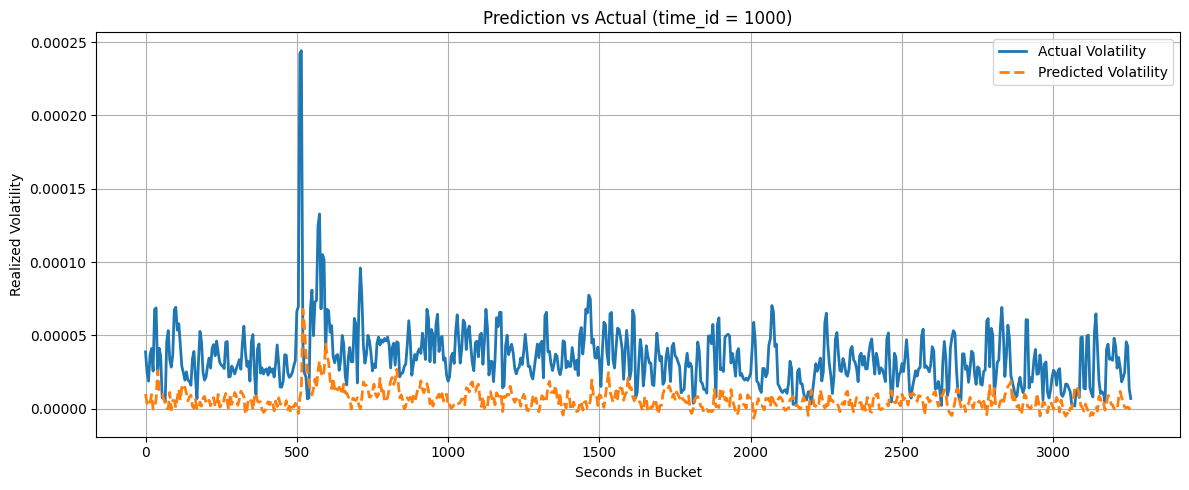

In [ ]:
util.plot_prediction_vs_actual(results_df, 2000, y_true_col='y_true', y_pred_col='y_pred')